# Kish Basin Salt Caverns

<https://hyss.ie/>

In [1]:
import glob
import itertools
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import shapely
import xarray as xr
from geocube.api.core import make_geocube
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# base data directory
DATA_DIR = os.path.join("data", "kish-basin")

crs = 23029

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Read data layers

In [3]:
def read_dat_file(dat_path: str, dat_crs):
    """
    Read XYZ data layers into an Xarray dataset
    """

    gdf = {}
    # for dat_file in glob.glob(os.path.join(dat_path, "*.dat")):
    for dat_file in [
        x for x in glob.glob(
            os.path.join(dat_path, "*.dat")
        ) if not "Zone" in x
    ]:

        # read each layer as individual dataframes into a dictionary
        gdf[os.path.split(dat_file)[-1][:-4]] = pd.read_fwf(
            dat_file, header=None, names=["X", "Y", "Z"]
        )

        # assign layer name to a column
        gdf[os.path.split(dat_file)[-1][:-4]]["data"] = (
            os.path.split(dat_file)[-1][:-4]
        )

    # find data resolution
    gdf_xr = (
        gdf[os.path.split(dat_file)[-1][:-4]].set_index(["X", "Y"]).to_xarray()
    )
    resx = gdf_xr["X"][1] - gdf_xr["X"][0]
    resy = gdf_xr["Y"][1] - gdf_xr["Y"][0]

    # combine dataframes
    gdf = pd.concat(gdf.values())

    # convert dataframe to geodataframe
    gdf["wkt"] = (
        "POINT (" + gdf["X"].astype(str) + " " + gdf["Y"].astype(str) + ")"
    )
    gdf = gpd.GeoDataFrame(
        gdf, geometry=gpd.GeoSeries.from_wkt(gdf["wkt"]), crs=dat_crs
    )
    gdf.drop(columns=["wkt", "X", "Y"], inplace=True)

    # convert to Xarray dataset
    ds = make_geocube(
        vector_data=gdf,
        resolution=(-abs(resy), abs(resx)),
        align=(abs(resy / 2), abs(resx / 2)),
        group_by="data"
    )

    # split variables and halite members
    ds_ = {}
    for dat in ds["data"].values:
        halite_member = dat.split(" ")[0]
        if halite_member == "Presall":
            halite_member = "Preesall"
        unit = dat.split(" ")[-1]
        zvar = dat.split("Halite ")[-1].split(" XYZ")[0]
        ds_[dat] = ds.sel(data=dat).assign_coords(
            halite=halite_member
        ).expand_dims(dim="halite").drop_vars("data")
        ds_[dat] = ds_[dat].rename({"Z": zvar.replace(" ", "")})
        ds_[dat][zvar.replace(" ", "")] = (
            ds_[dat][zvar.replace(" ", "")].assign_attrs(
                units=unit, long_name=zvar
            )
        )

    ds = xr.combine_by_coords(ds_.values(), combine_attrs="override")

    # # keep only points corresponding to zones of interest in the dataframe
    # zones = gdf.loc[gdf["data"].str.contains("Zone")]

    # # create zones of interest polygon
    # zones = gpd.GeoDataFrame(geometry=zones.buffer(100).envelope).dissolve()

    # create extent polygon
    extent = pd.read_csv(
        os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
    )
    extent = gpd.GeoSeries(
        shapely.geometry.Polygon([
            (extent[" X"][0], extent[" Y"][0]),
            (extent[" X"][1], extent[" Y"][1]),
            (extent[" X"][2], extent[" Y"][2]),
            (extent[" X"][3], extent[" Y"][3])
        ]),
        crs=crs
    )

    return ds, extent,  # zones

In [4]:
ds, extent = read_dat_file(DATA_DIR, dat_crs=crs)

In [5]:
xmin, ymin, xmax, ymax = extent.total_bounds

In [6]:
def plot_facet_maps(ds):
    """
    Plot facet maps of the halite layers
    """

    for v in ds.data_vars:
        fig = ds[v].plot.contourf(
            col="halite",
            robust=True,
            levels=15,
            cmap="jet",
            col_wrap=2,
            subplot_kws={"projection": ccrs.epsg(crs)},
            xlim=(xmin, xmax),
            ylim=(ymin, ymax)
        )
        # add a basemap
        basemap = cx.providers.CartoDB.PositronNoLabels
        for n, axis in enumerate(fig.axs.flat):
            cx.add_basemap(axis, crs=crs, source=basemap, attribution=False)
            # add attribution for basemap tiles
            if n == 2:
                axis.text(
                    xmin, ymin - 2500, basemap["attribution"], fontsize=8
                )
        fig.set_titles("{value}", weight="semibold")
        plt.show()

In [7]:
ds

<xarray.Dataset>
Dimensions:      (halite: 4, y: 237, x: 218)
Coordinates:
  * y            (y) float64 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x            (x) float64 6.966e+05 6.968e+05 6.97e+05 ... 7.398e+05 7.4e+05
    spatial_ref  int64 0
  * halite       (halite) <U8 'Flyde' 'Mythop' 'Preesall' 'Rossall'
Data variables:
    BaseDepth    (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    Thickness    (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TopDepth     (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TopTWT       (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [8]:
ds.rio.crs

CRS.from_epsg(23029)

In [9]:
ds.rio.resolution()

(200.0, -200.0)

In [10]:
ds.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

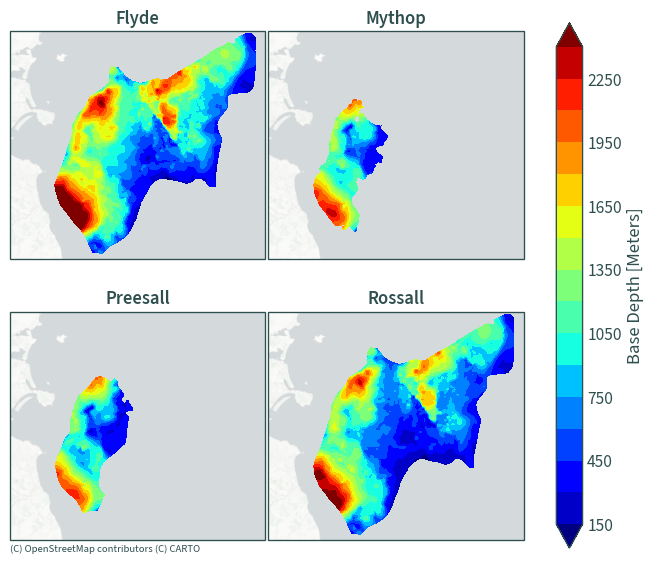

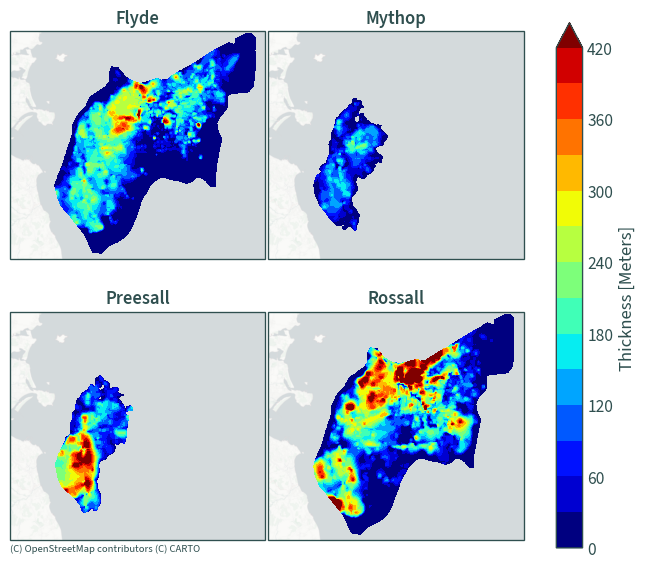

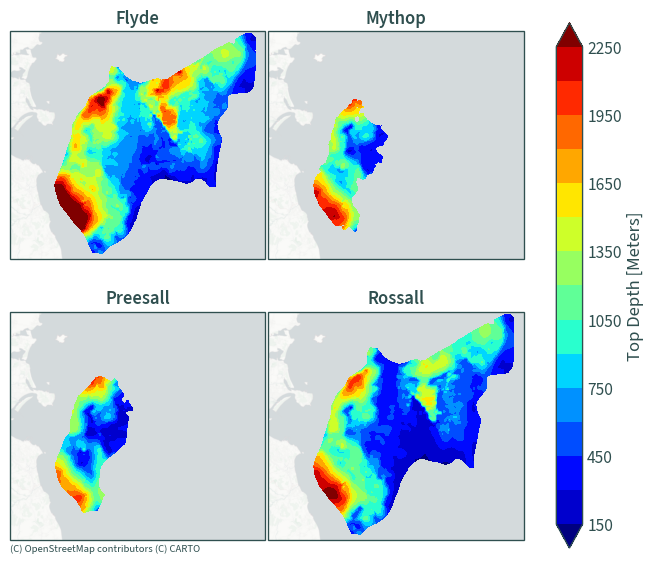

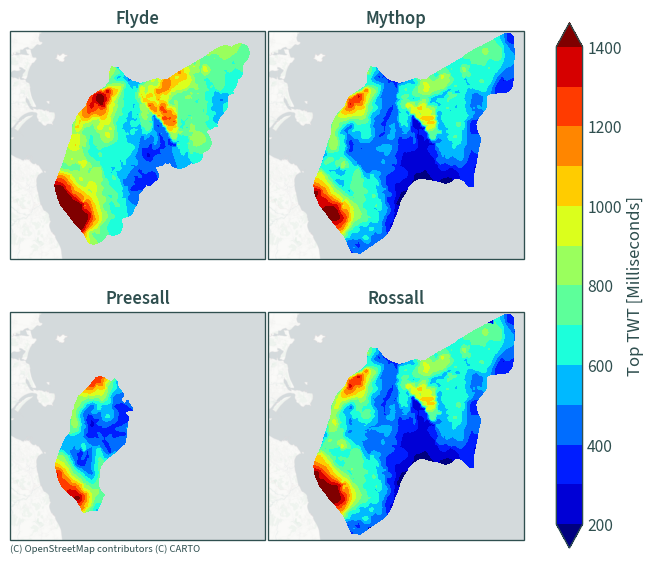

In [11]:
plot_facet_maps(ds)

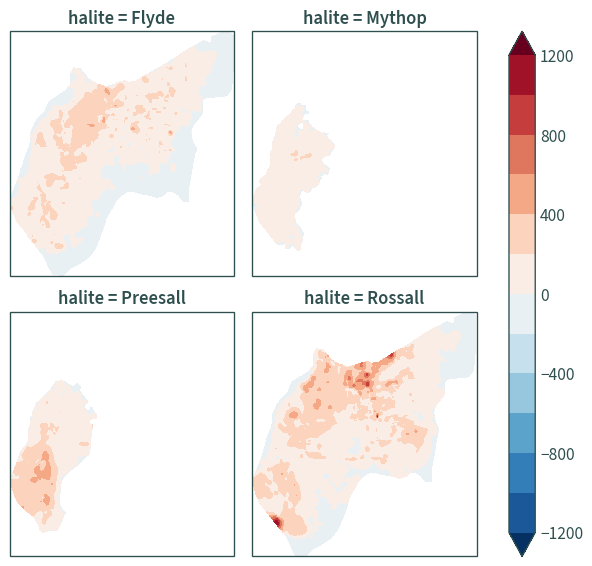

In [12]:
# compare depths
(ds["BaseDepth"] - ds["TopDepth"]).plot.contourf(
    col="halite", col_wrap=2, levels=15, extend="both",
    subplot_kws={"projection": ccrs.epsg(crs)}
)
plt.show()

In [13]:
min(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

-53.5

In [14]:
max(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

1111.0679

<!-- ### Zones of interest boundaries -->

In [15]:
# zones

In [16]:
# zones.bounds

In [17]:
# # use extent bounds
# xmin, ymin, xmax, ymax = extent.total_bounds

In [18]:
# ax = plt.axes(projection=ccrs.epsg(crs))
# zones.boundary.plot(color="darkslategrey", linewidth=1, ax=ax)
# ds.sel(
#     data=[x for x in ds["data"].values if "Zone" in x]
# ).max(dim="data")["Z"].plot(
#     cmap="jet",
#     alpha=.5,
#     levels=15,
#     robust=True,
#     cbar_kwargs={"label": "Halite Thickness (m)"},
#     xlim=(xmin, xmax),
#     ylim=(ymin, ymax)
# )
# cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.Voyager, zoom=10)
# plt.title(None)
# plt.tight_layout()
# plt.show()

## Generate potential salt cavern locations

### Caglayan *et al.* (2020)

<https://doi.org/10.1016/j.ijhydene.2019.12.161>

#### Zones of interest and cavern functions

In [19]:
def zones_of_interest_caglayan_etal(
    ds, min_thickness, min_depth, max_depth
):
    """
    Generate a (multi)polygon of the zones of interest by applying thickness
    and depth constraints suggested by Caglayan et al. (2020) to the halite
    layers.

    Parameters
    ----------
    ds : xarray dataset of the halite data
    min_thickness : minimum halite thickness [m]
    min_depth : minimum halite top depth [m]
    max_depth : maximum halite top depth [m]

    Returns
    -------
    - A (multi)polygon geodataframe of the zones of interest
    """

    zdf = ds.where(
        (
            (ds.Thickness >= min_thickness)
            & (ds.TopDepth >= min_depth)
            & (ds.TopDepth <= max_depth)
        ),
        drop=True
    )
    if plot_facet:
        plot_facet_maps(zdf)

    # zones of interest polygon
    zdf = zdf.max(
        dim="halite"
    )["Thickness"].to_dataframe().dropna().reset_index()
    zdf = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries(
            gpd.points_from_xy(zdf.x, zdf.y)
        ).buffer(100).envelope,
        crs=crs
    ).dissolve()

    ax = plt.axes(projection=ccrs.epsg(crs))
    zdf.boundary.plot(ax=ax, linewidth=1, color="darkslategrey")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=crs)
    plt.title("Zones of interest")
    plt.tight_layout()
    plt.show()

    return zdf

In [20]:
def generate_caverns_caglayan_etal(diameter, separation):
    """
    Generate salt caverns using a regular grid within the zones of interest
    based on the methodology by Caglayan et al. (2020):
    https://doi.org/10.1016/j.ijhydene.2019.12.161.
    Gridding method based on
    https://james-brennan.github.io/posts/fast_gridding_geopandas/.

    Parameters
    ----------
    diameter : diameter of the cavern [m]
    separation : cavern separation distance [m]

    Returns
    -------
    - A polygon geodataframe of potential caverns
    """

    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax + separation, separation):
        for y0 in np.arange(ymin, ymax + separation, separation):
            # bounds
            x1 = x0 - separation
            y1 = y0 + separation
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
    grid_cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)

    # verify separation distance
    if x0 - x1 == y1 - y0:

        # generate caverns within the zones of interest
        caverns = gpd.sjoin(
            gpd.GeoDataFrame(
                geometry=grid_cells.centroid.buffer(diameter / 2)
            ),
            zdf,
            predicate="within"
        )

        # estimations based on Caglayan et al. (2020)
        print("Number of potential caverns:", len(caverns))
        print(
            "Total volume:",
            "{:.2E}".format(len(caverns) * 5e5), f"m\N{SUPERSCRIPT THREE}"
        )
        print(
            "Estimated storage capacity:",
            "{:.2f}".format(len(caverns) * 146.418 / 1e3), "TWh"
        )

    else:
        print("x and y separation distances do not match!")

    return caverns

In [21]:
def plot_map(data, var, stat):
    """
    Plot halite layer and caverns within the zones of interest
    """

    plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.epsg(crs))

    cbar_label = f"{data[var].attrs['long_name']} [{data[var].attrs['units']}]"

    if stat == "max":
        plot_data = data.max(dim="halite", skipna=True)
        cbar_label = f"Maximum {cbar_label}"
    elif stat == "min":
        plot_data = data.min(dim="halite", skipna=True)
        cbar_label = f"Minimum {cbar_label}"
    elif stat == "mean":
        plot_data = data.mean(dim="halite", skipna=True)
        cbar_label = f"Mean {cbar_label}"

    plot_data[var].plot.contourf(
        cmap="jet",
        alpha=.65,
        robust=True,
        levels=15,
        xlim=(xmin, xmax),
        ylim=(ymin, ymax),
        cbar_kwargs={"label": cbar_label}
    )
    caverns.centroid.plot(
        ax=ax, markersize=7, color="black", label="Cavern", edgecolor="none"
    )
    cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.Voyager)
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=.25, color="darkslategrey"
    )
    ax.add_artist(ScaleBar(
        1, box_alpha=0,  # font_properties={"size": "large"},
        location="lower right", color="darkslategrey"
    ))
    plt.legend(loc="lower right", bbox_to_anchor=(1, 0.05), markerscale=1.75)
    plt.title("Potential Kish Basin Caverns within Zones of Interest")
    plt.tight_layout()
    plt.show()

#### Generate caverns

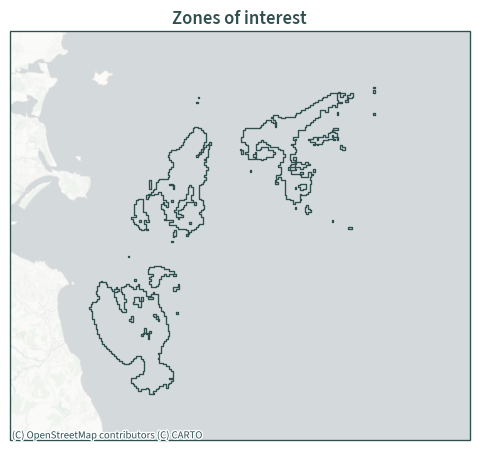

In [22]:
# salt thickness >= 200 m, top depth >= 1000 m and <= 2000 m
zdf = zones_of_interest_caglayan_etal(ds, 200, 1000, 2000)

In [23]:
# 84 m diameter, separation distance of 4 times the diameter
caverns = generate_caverns_caglayan_etal(84, 84 * 4)

Number of potential caverns: 1464
Total volume: 7.32E+08 m³
Estimated storage capacity: 214.36 TWh


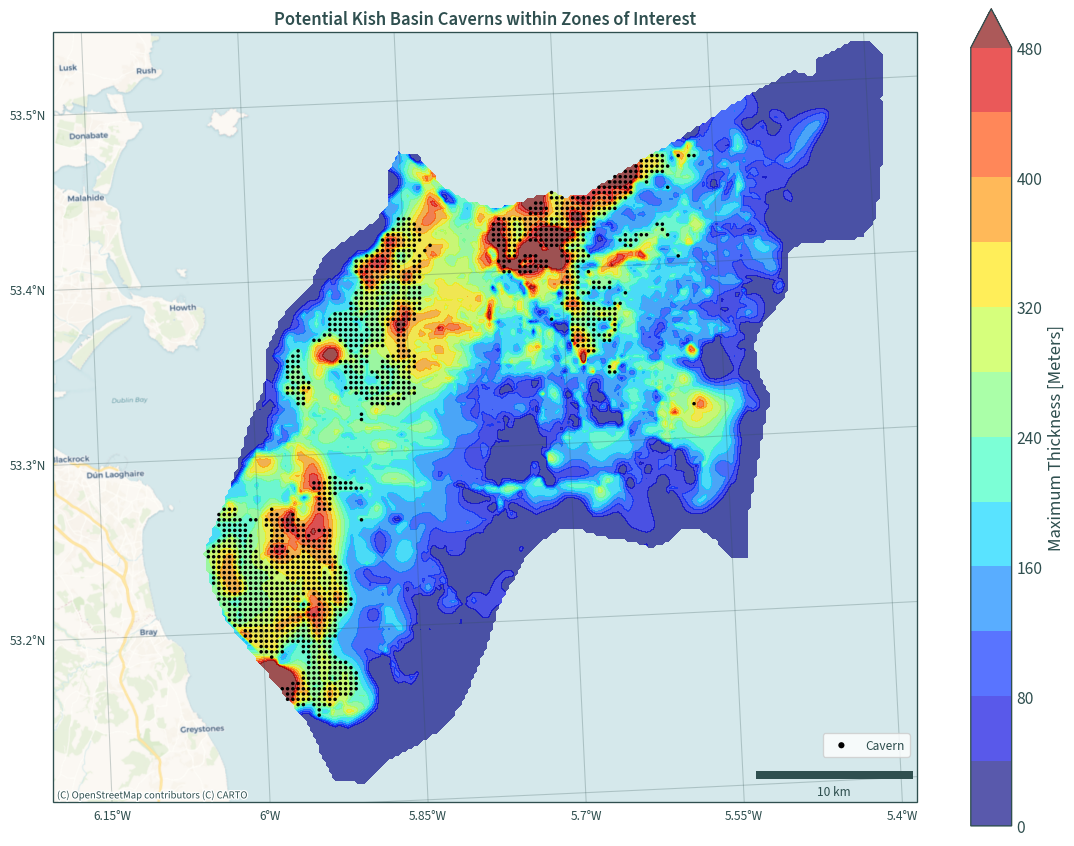

In [24]:
plot_map(ds, "Thickness", "max")

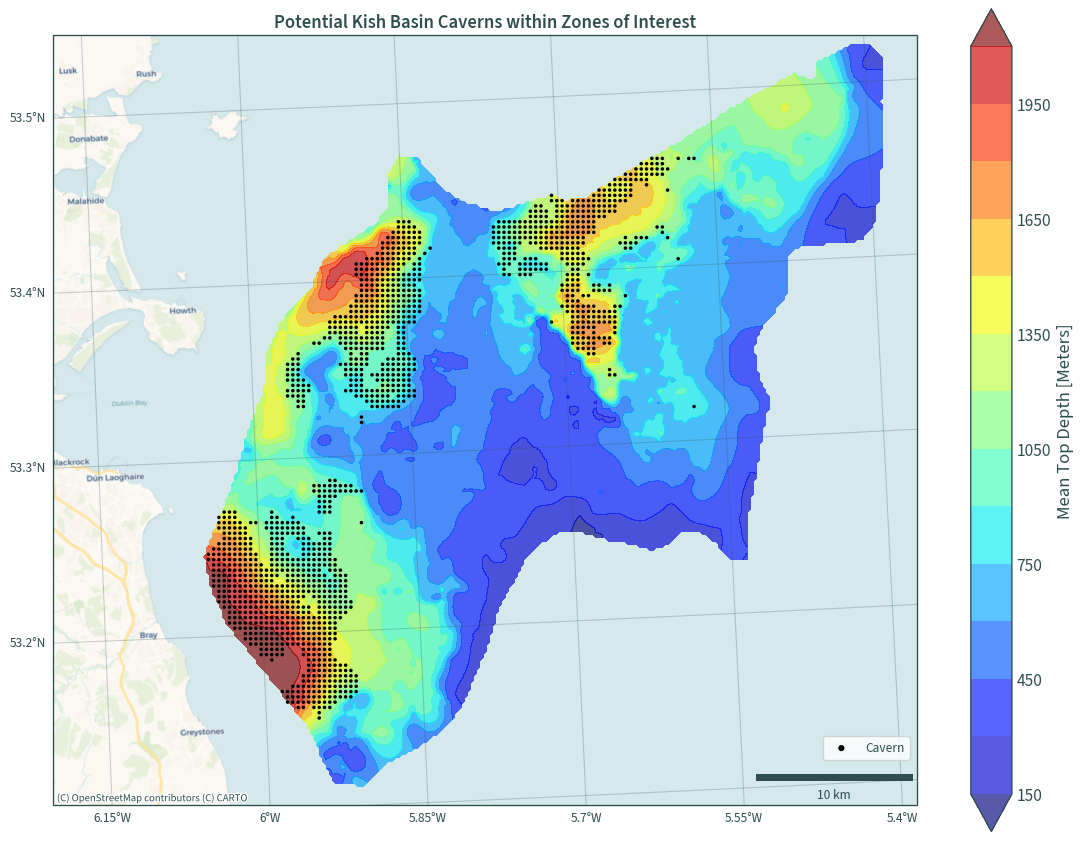

In [25]:
plot_map(ds, "TopDepth", "mean")

#### HYSS initial calculations

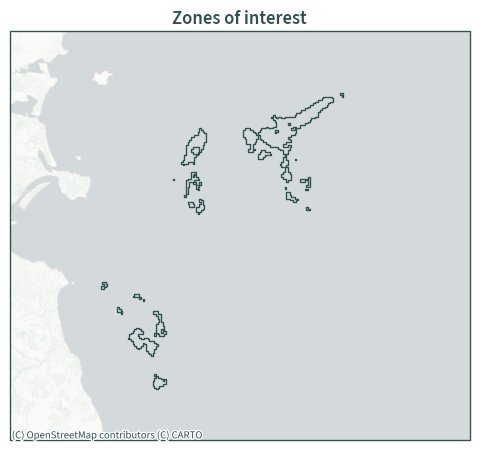

In [26]:
# salt thickness >= 300 m, top depth >= 1000 m and <= 1500 m
zdf = zones_of_interest_caglayan_etal(ds, 300, 1000, 1500)

In [27]:
# 85 m diameter, 330 m separation
caverns = generate_caverns_caglayan_etal(85, 330)

Number of potential caverns: 346
Total volume: 1.73E+08 m³
Estimated storage capacity: 50.66 TWh


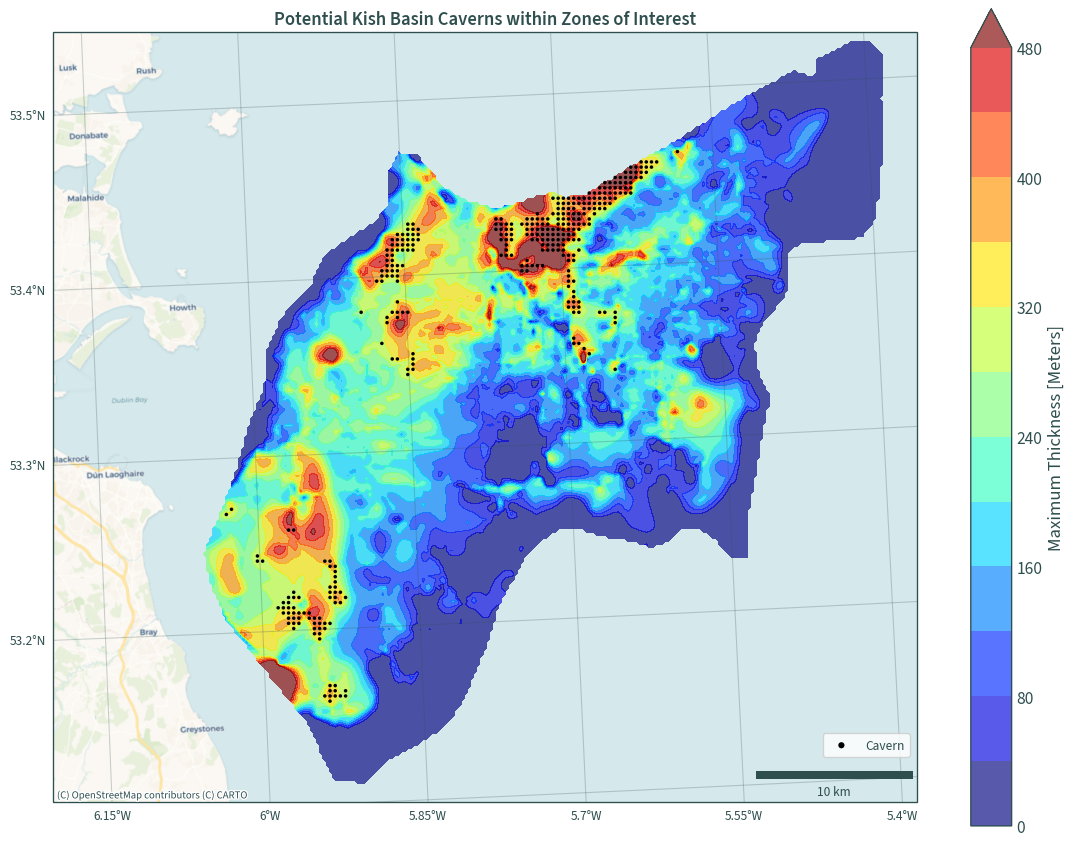

In [28]:
plot_map(ds, "Thickness", "max")

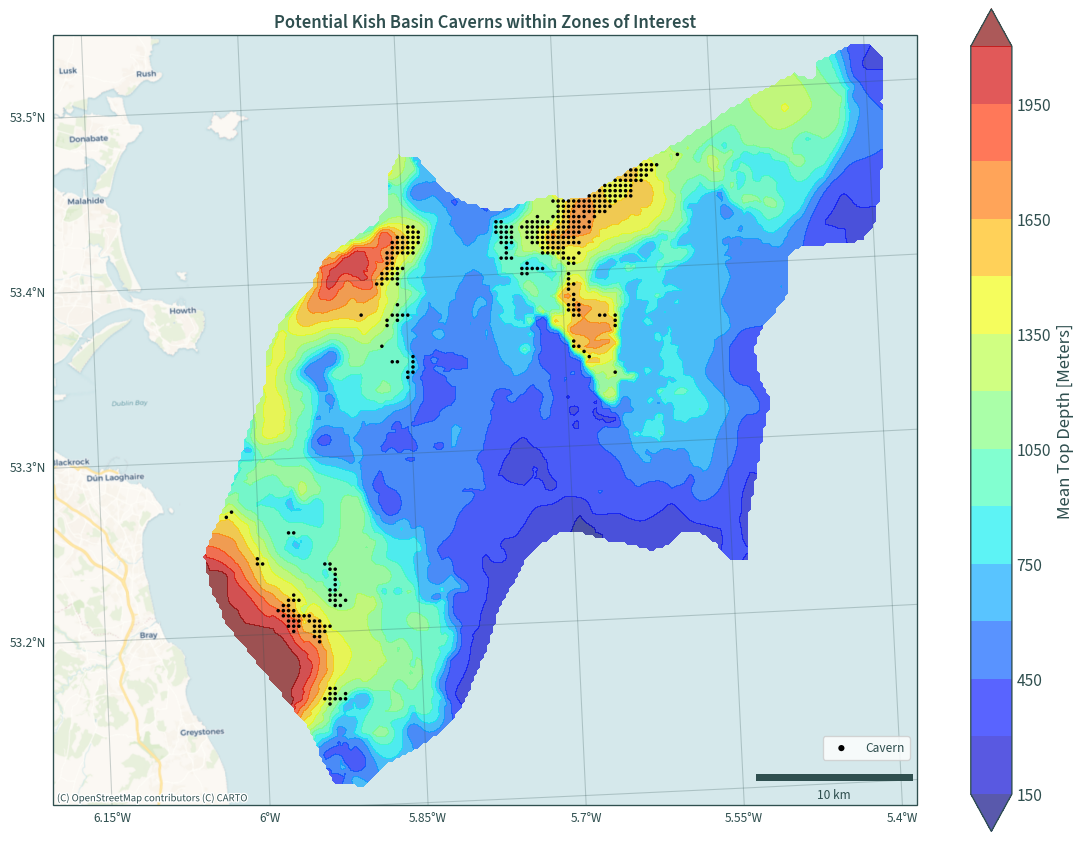

In [29]:
plot_map(ds, "TopDepth", "mean")